In [1]:
import numpy as np
from scipy.stats import multivariate_normal

def GMM_M_Step_numpy(X, Gamma, ClusterNo, eps=1e-8):
    """
    NumPy implementation of the GMM M-step.

    Parameters
    ----------
    X : ndarray, shape (N, 3)
        Input data (each row is a data point with 3 features: D, h, s).
    Gamma : ndarray, shape (N, K)
        Responsibility matrix (N samples × K clusters).
    ClusterNo : int
        Number of clusters.
    eps : float
        Small value to avoid division by zero.

    Returns
    -------
    log_likelihood : float
        Average negative log likelihood.
    Mu : ndarray, shape (K, 3)
        Cluster means.
    Std : ndarray, shape (K, 3)
        Cluster standard deviations.
    """

    N, D = X.shape
    assert D == 3, "X must have 3 features (D, h, s)"
    assert Gamma.shape == (N, ClusterNo), "Gamma shape must be (N, ClusterNo)"

    # Normalize Gamma just in case
    Gamma = Gamma / (Gamma.sum(axis=1, keepdims=True) + eps)

    # Effective cluster weights
    S = Gamma.sum(axis=0) + eps  # shape (K,)

    # Means (Mu)
    Mu = (Gamma.T @ X) / S[:, None]   # shape (K, 3)

    # Variances (diagonal, per feature)
    diff = X[:, None, :] - Mu[None, :, :]   # shape (N, K, 3)
    Var = (Gamma[:, :, None] * diff**2).sum(axis=0) / S[:, None]  # shape (K, 3)
    Std = np.sqrt(Var + eps)

    # Likelihood
    probs = np.zeros((N, ClusterNo))
    for k in range(ClusterNo):
        cov = np.diag(Std[k]**2)
        probs[:, k] = multivariate_normal.pdf(X, mean=Mu[k], cov=cov) * (S[k] / S.sum())

    Prob = probs.sum(axis=1) + eps
    Log_Prob = -np.log(Prob)
    Log_Likelihood = Log_Prob.mean()

    return Log_Likelihood, Mu, Std


In [2]:
# Fake data (N=100 points, 3 features)
X = np.random.rand(100, 3)

# Random responsibilities (N=100, K=3 clusters)
Gamma = np.random.dirichlet(np.ones(3), size=100)

log_lik, Mu, Std = GMM_M_Step_numpy(X, Gamma, ClusterNo=3)

print("Log-Likelihood:", log_lik)
print("Cluster Means:\n", Mu)
print("Cluster Stds:\n", Std)


Log-Likelihood: 0.5614903515424635
Cluster Means:
 [[0.5323039  0.49254404 0.50487713]
 [0.4759941  0.5180266  0.53287378]
 [0.51546556 0.5618994  0.50649439]]
Cluster Stds:
 [[0.30815716 0.30992664 0.26597127]
 [0.29619738 0.29178934 0.29000022]
 [0.29715439 0.29156512 0.26406624]]


In [3]:
import numpy as np
from scipy.stats import multivariate_normal

class GMM:
    def __init__(self, n_clusters=3, max_iter=100, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = np.random.RandomState(random_state)

    def initialize_params(self, X):
        N, D = X.shape
        # Initialize means as random samples
        self.mu = X[self.random_state.choice(N, self.n_clusters, replace=False)]
        # Initialize standard deviations (diagonal covariance)
        self.std = np.ones((self.n_clusters, D))
        # Mixing coefficients
        self.pi = np.ones(self.n_clusters) / self.n_clusters

    def e_step(self, X):
        N, D = X.shape
        gamma = np.zeros((N, self.n_clusters))

        for k in range(self.n_clusters):
            cov = np.diag(self.std[k]**2)
            gamma[:, k] = self.pi[k] * multivariate_normal.pdf(X, mean=self.mu[k], cov=cov)

        gamma = gamma / (gamma.sum(axis=1, keepdims=True) + 1e-8)
        return gamma

    def m_step(self, X, gamma):
        N, D = X.shape
        Nk = gamma.sum(axis=0) + 1e-8  # effective cluster sizes

        # Update means
        self.mu = (gamma.T @ X) / Nk[:, None]

        # Update variances
        diff = X[:, None, :] - self.mu[None, :, :]
        var = (gamma[:, :, None] * diff**2).sum(axis=0) / Nk[:, None]
        self.std = np.sqrt(var + 1e-8)

        # Update mixing coefficients
        self.pi = Nk / N

    def log_likelihood(self, X):
        N, D = X.shape
        probs = np.zeros((N, self.n_clusters))

        for k in range(self.n_clusters):
            cov = np.diag(self.std[k]**2)
            probs[:, k] = self.pi[k] * multivariate_normal.pdf(X, mean=self.mu[k], cov=cov)

        log_lik = np.log(probs.sum(axis=1) + 1e-8).sum()
        return log_lik

    def fit(self, X):
        self.initialize_params(X)
        prev_log_lik = None

        for i in range(self.max_iter):
            gamma = self.e_step(X)
            self.m_step(X, gamma)
            log_lik = self.log_likelihood(X)

            if prev_log_lik is not None and abs(log_lik - prev_log_lik) < self.tol:
                break
            prev_log_lik = log_lik

        return self

    def predict(self, X):
        gamma = self.e_step(X)
        return np.argmax(gamma, axis=1)

    def predict_proba(self, X):
        return self.e_step(X)


In [4]:
# Generate synthetic data (3 clusters in 3D)
np.random.seed(42)
X1 = np.random.normal([2, 2, 2], 0.3, size=(100, 3))
X2 = np.random.normal([-2, -2, 0], 0.5, size=(100, 3))
X3 = np.random.normal([0, 4, -1], 0.4, size=(100, 3))
X = np.vstack([X1, X2, X3])

# Fit GMM
gmm = GMM(n_clusters=3, max_iter=200, random_state=42)
gmm.fit(X)

# Predictions
labels = gmm.predict(X)
print("Cluster Means:\n", gmm.mu)
print("Cluster Std:\n", gmm.std)
print("Mixing Coefficients:", gmm.pi)


Cluster Means:
 [[ 0.03041221  4.02905932 -0.96083863]
 [ 2.02752976  1.94502999  2.02244647]
 [-1.98341437 -2.05528249  0.0064617 ]]
Cluster Std:
 [[0.35892546 0.39487787 0.43635886]
 [0.24619942 0.29225764 0.3321993 ]
 [0.47775246 0.51309882 0.44348022]]
Mixing Coefficients: [0.33333324 0.33333326 0.3333331 ]


In [5]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

class GMM:
    def __init__(self, n_clusters=3, max_iter=100, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = np.random.RandomState(random_state)

    def initialize_params(self, X):
        N, D = X.shape
        self.mu = X[self.random_state.choice(N, self.n_clusters, replace=False)]
        self.std = np.ones((self.n_clusters, D))
        self.pi = np.ones(self.n_clusters) / self.n_clusters

    def e_step(self, X):
        N, D = X.shape
        gamma = np.zeros((N, self.n_clusters))

        for k in range(self.n_clusters):
            cov = np.diag(self.std[k]**2)
            gamma[:, k] = self.pi[k] * multivariate_normal.pdf(X, mean=self.mu[k], cov=cov)

        gamma = gamma / (gamma.sum(axis=1, keepdims=True) + 1e-8)
        return gamma

    def m_step(self, X, gamma):
        N, D = X.shape
        Nk = gamma.sum(axis=0) + 1e-8

        self.mu = (gamma.T @ X) / Nk[:, None]
        diff = X[:, None, :] - self.mu[None, :, :]
        var = (gamma[:, :, None] * diff**2).sum(axis=0) / Nk[:, None]
        self.std = np.sqrt(var + 1e-8)
        self.pi = Nk / N

    def log_likelihood(self, X):
        N, D = X.shape
        probs = np.zeros((N, self.n_clusters))

        for k in range(self.n_clusters):
            cov = np.diag(self.std[k]**2)
            probs[:, k] = self.pi[k] * multivariate_normal.pdf(X, mean=self.mu[k], cov=cov)

        return np.log(probs.sum(axis=1) + 1e-8).sum()

    def fit(self, X):
        self.initialize_params(X)
        prev_log_lik = None

        for i in range(self.max_iter):
            gamma = self.e_step(X)
            self.m_step(X, gamma)
            log_lik = self.log_likelihood(X)

            if prev_log_lik is not None and abs(log_lik - prev_log_lik) < self.tol:
                break
            prev_log_lik = log_lik

        return self

    def predict(self, X):
        gamma = self.e_step(X)
        return np.argmax(gamma, axis=1)

    def predict_proba(self, X):
        return self.e_step(X)

    def plot_clusters(self, X):
        labels = self.predict(X)

        # Reduce to 2D for visualization
        X_2d = PCA(n_components=2).fit_transform(X)

        plt.figure(figsize=(8,6))
        for k in range(self.n_clusters):
            plt.scatter(X_2d[labels==k, 0], X_2d[labels==k, 1], label=f"Cluster {k}", alpha=0.6)

        plt.title("GMM Clusters (PCA-reduced to 2D)")
        plt.legend()
        plt.show()


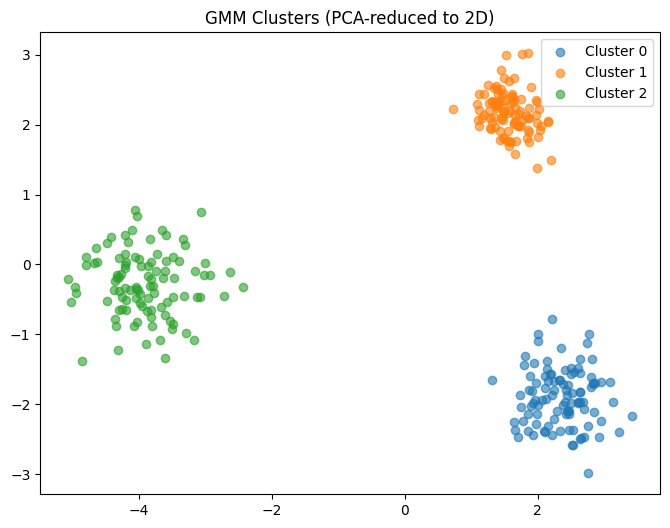

In [6]:
# Generate synthetic 3D data
np.random.seed(42)
X1 = np.random.normal([2, 2, 2], 0.3, size=(100, 3))
X2 = np.random.normal([-2, -2, 0], 0.5, size=(100, 3))
X3 = np.random.normal([0, 4, -1], 0.4, size=(100, 3))
X = np.vstack([X1, X2, X3])

# Train GMM
gmm = GMM(n_clusters=3, max_iter=200, random_state=42)
gmm.fit(X)

# Plot clusters
gmm.plot_clusters(X)


In [9]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.patches import Ellipse

class GMM:
    def __init__(self, n_clusters=3, max_iter=100, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = np.random.RandomState(random_state)

    def initialize_params(self, X):
        N, D = X.shape
        self.mu = X[self.random_state.choice(N, self.n_clusters, replace=False)]
        self.std = np.ones((self.n_clusters, D))
        self.pi = np.ones(self.n_clusters) / self.n_clusters

    def e_step(self, X):
        N, D = X.shape
        gamma = np.zeros((N, self.n_clusters))

        for k in range(self.n_clusters):
            cov = np.diag(self.std[k]**2)
            gamma[:, k] = self.pi[k] * multivariate_normal.pdf(X, mean=self.mu[k], cov=cov)

        gamma = gamma / (gamma.sum(axis=1, keepdims=True) + 1e-8)
        return gamma

    def m_step(self, X, gamma):
        N, D = X.shape
        Nk = gamma.sum(axis=0) + 1e-8

        self.mu = (gamma.T @ X) / Nk[:, None]
        diff = X[:, None, :] - self.mu[None, :, :]
        var = (gamma[:, :, None] * diff**2).sum(axis=0) / Nk[:, None]
        self.std = np.sqrt(var + 1e-8)
        self.pi = Nk / N

    def log_likelihood(self, X):
        N, D = X.shape
        probs = np.zeros((N, self.n_clusters))

        for k in range(self.n_clusters):
            cov = np.diag(self.std[k]**2)
            probs[:, k] = self.pi[k] * multivariate_normal.pdf(X, mean=self.mu[k], cov=cov)

        return np.log(probs.sum(axis=1) + 1e-8).sum()

    def fit(self, X):
        self.initialize_params(X)
        prev_log_lik = None

        for i in range(self.max_iter):
            gamma = self.e_step(X)
            self.m_step(X, gamma)
            log_lik = self.log_likelihood(X)

            if prev_log_lik is not None and abs(log_lik - prev_log_lik) < self.tol:
                break
            prev_log_lik = log_lik

        return self

    def predict(self, X):
        gamma = self.e_step(X)
        return np.argmax(gamma, axis=1)

    def predict_proba(self, X):
        return self.e_step(X)

    def plot_clusters(self, X):
        labels = self.predict(X)

        # Reduce to 2D for visualization
        pca = PCA(n_components=2)
        X_2d = pca.fit_transform(X)

        # Transform means and variances into 2D space
        mu_2d = pca.transform(self.mu)
        std_2d = self.std[:, :2]  # only approximate, PCA distorts variances

        plt.figure(figsize=(8,6))
        for k in range(self.n_clusters):
            plt.scatter(X_2d[labels==k, 0], X_2d[labels==k, 1], label=f"Cluster {k}", alpha=0.6)

            # Draw ellipse for Gaussian spread
            cov_matrix = np.diag(std_2d[k]**2)
            vals, vecs = np.linalg.eigh(cov_matrix)
            order = vals.argsort()[::-1]
            vals, vecs = vals[order], vecs[:, order]
            theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

            # 2 std devs -> ~95% confidence ellipse
            width, height = 2 * np.sqrt(vals)
            ellip = Ellipse(mu_2d[k], width, height, angle=theta,
                edgecolor='black', fc='None', lw=2)
            plt.gca().add_patch(ellip)

        plt.title("GMM Clusters with Ellipses (PCA-reduced to 2D)")
        plt.legend()
        plt.show()


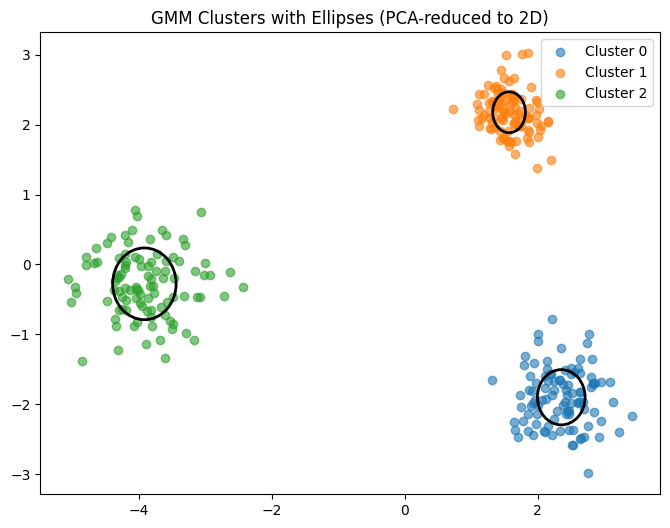

In [10]:
# Generate synthetic 3D data
np.random.seed(42)
X1 = np.random.normal([2, 2, 2], 0.3, size=(100, 3))
X2 = np.random.normal([-2, -2, 0], 0.5, size=(100, 3))
X3 = np.random.normal([0, 4, -1], 0.4, size=(100, 3))
X = np.vstack([X1, X2, X3])

# Train GMM
gmm = GMM(n_clusters=3, max_iter=200, random_state=42)
gmm.fit(X)

# Plot clusters with ellipses
gmm.plot_clusters(X)
